## Customer Clustering Project
This project aims to cluster customers based on their purchasing behavior using the 'Online Retail II' dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/502/online+retail+ii).
The dataset should be placed in a `data` folder for processing.

# Sarting the project

## Importing neccessary Libs.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from ydata_profiling import ProfileReport
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# # making the numbers easier to read on display
pd.options.display.float_format = '{:20.2f}'.format

# # show all columns
pd.set_option('display.max_columns', 999)
%matplotlib inline

d:\Mahmoud\Work\python_projects\needed files\environments\datascience\ds-base\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Exploration 

### *data description*
* *Invoice: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.*
* *StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.*
* *Description: Product (item) name. Nominal.*
* *Quantity: The quantities of each product (item) per transaction. Numeric.*
* *InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.*
* *Price: Unit price. Numeric. Product price per unit in sterling (Â£).*
* *Customer ID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.*
* *Country: Country name. Nominal. The name of the country where a customer resides.*

### Reading the data

In [3]:
# df = pd.read_excel('./data/online_retail.xlsx', sheet_name=0)
# df.head()

In [4]:
# # to csv as it is easier to work with 
# df.to_csv('./data/online_retail.csv', index=False)
# csv = pd.read_csv('./data/online_retail.csv')
# csv.head()

In [5]:
df = pd.read_csv('./data/online_retail.csv', parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


### renaming the columns

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns 

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country'],
      dtype='object')

### getting info about the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      525461 non-null  object        
 1   stockcode    525461 non-null  object        
 2   description  522533 non-null  object        
 3   quantity     525461 non-null  int64         
 4   invoicedate  525461 non-null  datetime64[ns]
 5   price        525461 non-null  float64       
 6   customer_id  417534 non-null  float64       
 7   country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [8]:
df.describe()

,quantity,invoicedate,price,customer_id
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


In [9]:
df.describe(include='O')

,invoice,stockcode,description,country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


***notes***:
* *525461 rows, 8 columns*
* *null = {'description':2928, 'customer_id':107927}*
* *(price, quantity) has negaive nums*
* *the mode for (stock, desc) is 85123A	WHITE HANGING HEART T-LIGHT HOLDER but it seems data needs cleaning*




In [10]:
df[df["customer_id"].isna()].head(10)

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [11]:
df[df['quantity'] < 0]

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


## Explring columns

### looking into invoice column

In [12]:
df[df["invoice"].str.match("^\\d{6}$") == False]

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


In [13]:
df['invoice'].str.extract(r'(\w)').value_counts()
# df["invoice"].str.replace("[0-9]", "", regex=True).unique()

0
5    406763
4    108489
C     10206
A         3
Name: count, dtype: int64

***Note***: *invoice can start with either of 3 charechters (digit, 'C', 'A')*

In [14]:
df[df['invoice'].str.startswith('A')]

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


***Note***: *The transactions that start with 'A' are the adjusted transactions. These transactions are used to correct mistakes in the data for accounting purposes. These transactions are not real transactions. we will drop them*


### looking into stockcode column

In [15]:
df[~(df['stockcode'].str.match(r'^\d{5}$'))]#look for stockcodes that are not 5 digits long

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


***Note:*** 
* *stockcode should be a string of 5 digits only but we have some stockcodes that are not 5 digits*

In [16]:
# look for stockcodes that are not 5 digits long and do not end with a letter 
stock_vlues_to_check = df[(df["stockcode"].str.match("^\\d{5}$") == False) & (df["stockcode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["stockcode"].unique()
print(stock_vlues_to_check)

['POST' 'D' 'DCGS0058' 'DCGS0068' 'DOT' 'M' 'DCGS0004' 'DCGS0076' 'C2'
 'BANK CHARGES' 'DCGS0003' 'TEST001' 'gift_0001_80' 'DCGS0072'
 'gift_0001_20' 'DCGS0044' 'TEST002' 'gift_0001_10' 'gift_0001_50'
 'DCGS0066N' 'gift_0001_30' 'PADS' 'ADJUST' 'gift_0001_40' 'gift_0001_60'
 'gift_0001_70' 'gift_0001_90' 'DCGSSGIRL' 'DCGS0006' 'DCGS0016'
 'DCGS0027' 'DCGS0036' 'DCGS0039' 'DCGS0060' 'DCGS0056' 'DCGS0059' 'GIFT'
 'DCGSLBOY' 'm' 'DCGS0053' 'DCGS0062' 'DCGS0037' 'DCGSSBOY' 'DCGSLGIRL'
 'S' 'DCGS0069' 'DCGS0070' 'DCGS0075' 'B' 'DCGS0041' 'ADJUST2' '47503J '
 'C3' 'SP1002' 'AMAZONFEE']


In [17]:
df[df['stockcode'].str.match(r'^DCG')] #example of how we goin to examine the unkonwn stockcodes


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
2377,489597,DCGS0058,MISO PRETTY GUM,1,2009-12-01 14:28:00,0.83,NaN,United Kingdom
2378,489597,DCGS0068,DOGS NIGHT COLLAR,1,2009-12-01 14:28:00,8.65,NaN,United Kingdom
8371,490074,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2009-12-03 14:39:00,17.35,NaN,United Kingdom
8372,490074,DCGS0058,MISO PRETTY GUM,1,2009-12-03 14:39:00,0.83,NaN,United Kingdom
8373,490074,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-03 14:39:00,16.48,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
466308,533348,DCGSSBOY,BOYS PARTY BAG,1,2010-11-17 09:23:00,3.36,NaN,United Kingdom
478086,534289,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-22 11:25:00,2.51,NaN,United Kingdom
496962,535835,DCGSSBOY,BOYS PARTY BAG,3,2010-11-29 09:46:00,3.36,NaN,United Kingdom
496963,535835,DCGSSGIRL,GIRLS PARTY BAG,3,2010-11-29 09:46:00,3.36,NaN,United Kingdom


***Note:*** 
we need to go through each stockcode and check if it is a valid transaction or not as it is not clear in the data description

In [18]:
# # examinng the unknown stockcodes
# for value in stock_vlues_to_check:
#     print(f"{value}'s data")
#     print(df[df["stockcode"].str.match(f"^{value}$")].head().to_string())
#     print('='*200)
#     print('\n\n')

**Notes:**

**Stock Code**
* StockCode is meant to follow the pattern `[0-9]{5}` but seems to have legit values for `[0-9]{5}[a-zA-Z]+`
    * Also contains other values:
        | **Code**            | **Description**                                                        | **Action**              |
        |-----------------|------------------------------------------------------------------------|-------------------------|
        | DCGS            | Looks valid, some quantities are negative though and customer ID is null | Exclude from clustering |
        | D               | Looks valid, represents discount values                                | Exclude from clustering |
        | DOT             | Looks valid, represents postage charges                                | Exclude from clustering |
        | M or m          | Looks valid, represents manual transactions                            | Exclude from clustering |
        | C2              | Carriage transaction - not sure what this means                        | Exclude from clustering |
        | C3              | Not sure, only 1 transaction                                           | Exclude                 |
        | BANK CHARGES or B | Bank charges                                                        | Exclude from clustering |
        | S               | Samples sent to customer                                               | Exclude from clustering |
        | TESTXXX         | Testing data, not valid                                                | Exclude from clustering |
        | gift__XXX       | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
        | PADS            | Looks like a legit stock code for padding                              | Include                 |
        | SP1002          | Looks like a special request item, only 2 transactions, 3 look legit, 1 has 0 pricing | Exclude for now|
        | AMAZONFEE       | Looks like fees for Amazon shipping or something                       | Exclude for now         |
        | ADJUSTX         | Looks like manual account adjustments by admins                        | Exclude for now         |

## Data Cleaning

In [19]:
cleaned_df = df.copy()

### Cleaning invoice column

In [20]:
mask = (
    cleaned_df['invoice'].str.startswith('C') | 
    cleaned_df['invoice'].str.startswith('A') 
)
cleaned_df = cleaned_df[~mask]
cleaned_df 

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


### Cleaning stockcode column

In [21]:
cleaned_df.loc[:, 'stockcode'] = cleaned_df['stockcode'].str.strip().str.upper()
mask = (
    cleaned_df['stockcode'].str.match(r'^\d{5}')|    
    cleaned_df['stockcode'].str.match(r'^\d{5}[a-zA-Z]+$')|
    cleaned_df['stockcode'].str.match(r'^POST$')
)

cleaned_df = cleaned_df[mask]
cleaned_df

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [22]:
cleaned_df.describe(include='O')

,invoice,stockcode,description,country
count,513545,513545,510662,513545
unique,23880,4423,4627,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,674,3457,3456,475532


### Cleaning customer_id column

In [23]:
cleaned_df = cleaned_df.dropna(subset=['customer_id'])
cleaned_df

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [24]:
cleaned_df.describe()

,quantity,invoicedate,price,customer_id
count,407061.00,407061,407061.00,407061.00
mean,13.60,2010-07-01 10:31:56.322270976,3.04,15368.79
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,13996.00
50%,5.00,2010-07-09 15:48:00,1.95,15321.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,850.00,18287.00
std,96.92,NaN,4.81,1679.87


### Cleaning price column

In [25]:
cleaned_df[cleaned_df.price == 0 ].shape[0]

28

***Note:***
 *so by cleaning customer_id we got rid of negative values in price and quantity*
 *we still have zero values in price and we will drop them it's 28 rows only*

In [26]:
cleaned_df = cleaned_df[cleaned_df.price > 0]

In [27]:
cleaned_df.describe()

,quantity,invoicedate,price,customer_id
count,407033.00,407033,407033.00,407033.00
mean,13.60,2010-07-01 10:35:15.379981312,3.04,15368.87
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,13996.00
50%,5.00,2010-07-09 15:48:00,1.95,15321.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,850.00,18287.00
std,96.91,NaN,4.81,1679.83


In [28]:
cleaned_df.dtypes

invoice                object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
price                 float64
customer_id           float64
country                object
dtype: object

In [29]:
# profile = ProfileReport(cleaned_df, title="Profiling Report")
# profile.to_file("report.html")

## Feature Engineering

In [30]:
# create a new column for the total amount
cleaned_df['amount'] = cleaned_df['quantity'] * cleaned_df['price']
cleaned_df['amount'] = cleaned_df['amount'].round(2)

C:\Users\Raouf\AppData\Local\Temp\ipykernel_10972\2423604478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['amount'] = cleaned_df['quantity'] * cleaned_df['price']
C:\Users\Raouf\AppData\Local\Temp\ipykernel_10972\2423604478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['amount'] = cleaned_df['amount'].round(2)


In [31]:
# # separate the date and time
# cleaned_df['date'] = cleaned_df['invoicedate'].dt.date
# cleaned_df['time'] = cleaned_df['invoicedate'].dt.time

In [32]:
cleaned_df.head(2)

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00


In [33]:
last_date = cleaned_df['invoicedate'].max() + pd.DateOffset(days=1)
last_date

Timestamp('2010-12-10 20:01:00')

In [34]:
agg_df = cleaned_df.groupby(by='customer_id', as_index=False).agg(
    monetary = ('amount', 'sum'),
    frequency = ('invoice', 'nunique'),
    recency = ('invoicedate', lambda x: (last_date - x.max()).days + 1), # add 1 to include the last day
    # total_quantity = ('quantity', 'sum'),  
    # most_bought_item = ('stockcode', lambda x: x.mode().values[0]),
    
)
agg_df.head()

,customer_id,monetary,frequency,recency
0,12346.00,169.36,2,166
1,12347.00,1323.32,2,4
2,12348.00,222.16,1,75
3,12349.00,2671.14,3,44
4,12351.00,300.93,1,12


### Explaining the features
* monatary: total amount of money spent by the customer
* frequency: number of transactions\vists by the customer
* recency: number of days between last and first visit

### visualizing the features

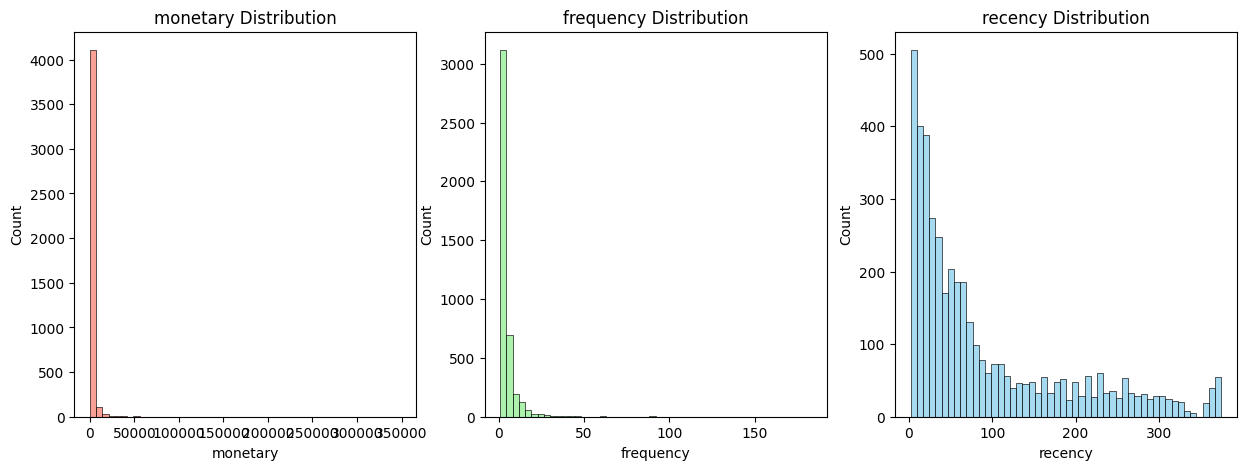

In [35]:
features = ['monetary', 'frequency', 'recency']
colosrs = ['salmon', 'lightgreen', 'skyblue']
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(agg_df[features[i]], bins=50, color=colosrs[i])
    plt.title(f'{features[i]} Distribution')
plt.show()


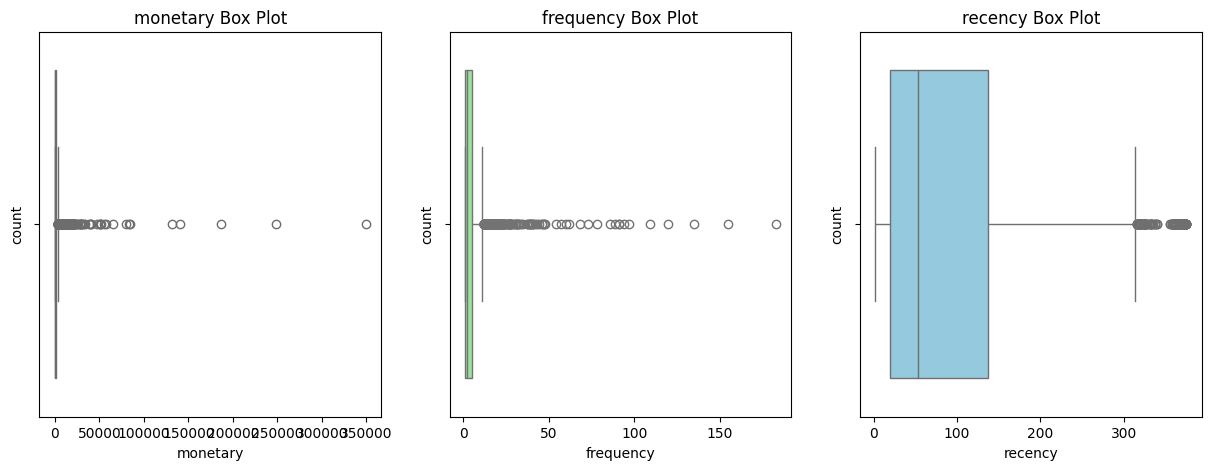

In [36]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.boxplot(agg_df[features[i]],color=colosrs[i], orient='h')
    plt.title(f'{features[i]} Box Plot')
    plt.xlabel(f'{features[i]}')
    plt.ylabel('count')
plt.show()

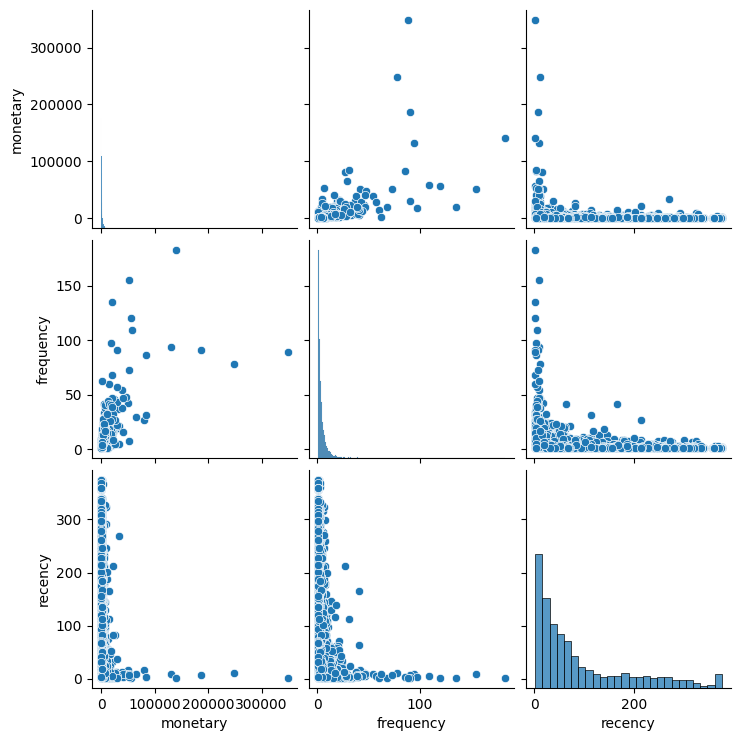

In [37]:
sns.pairplot(agg_df[['monetary', 'frequency', 'recency']])#, diag_kind='kde', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k', 'linewidth':0.5})

In [38]:
M_Q1 = agg_df["monetary"].quantile(0.25)
M_Q3 = agg_df["monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = agg_df[(agg_df["monetary"] > (M_Q3 + 1.5 * M_IQR)) | (agg_df["monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.shape

(420, 4)

In [39]:
F_Q1 = agg_df['frequency'].quantile(0.25)
F_Q3 = agg_df['frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = agg_df[(agg_df['frequency'] > (F_Q3 + 1.5 * F_IQR)) | (agg_df['frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()
frequency_outliers_df.shape

(283, 4)

In [40]:
non_outliers_df = agg_df[(~agg_df.index.isin(monetary_outliers_df.index)) & 
                         (~agg_df.index.isin(frequency_outliers_df.index))
                         ]

non_outliers_df.shape

(3812, 4)

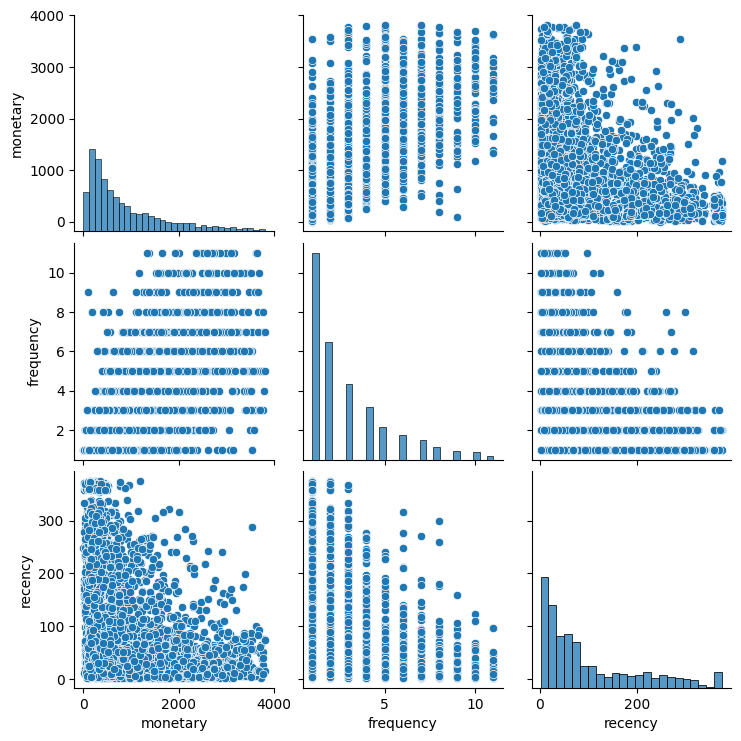

In [41]:
sns.pairplot(non_outliers_df[['monetary', 'frequency', 'recency']])

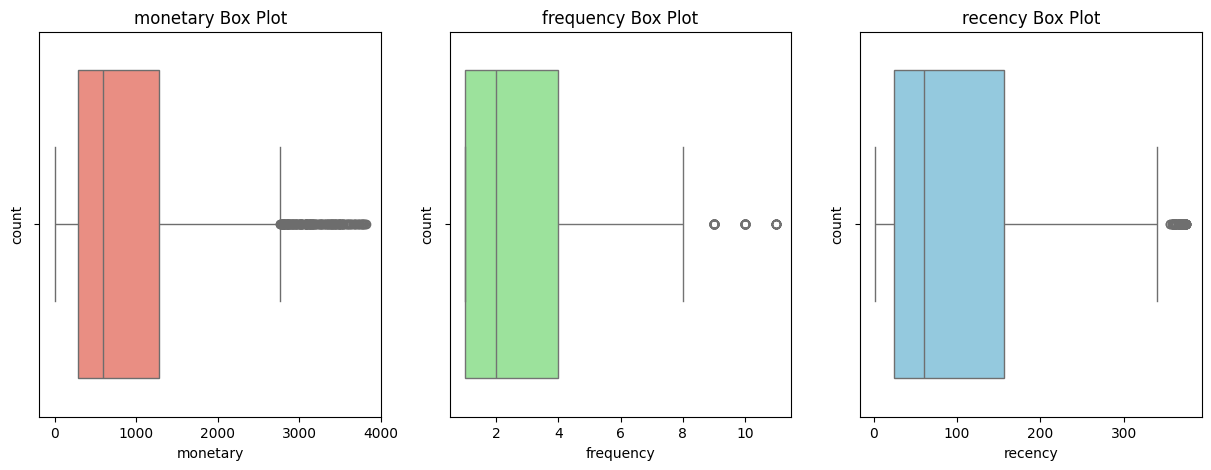

In [42]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.boxplot(non_outliers_df[features[i]],color=colosrs[i], orient='h')
    plt.title(f'{features[i]} Box Plot')
    plt.xlabel(f'{features[i]}')
    plt.ylabel('count')
plt.show()

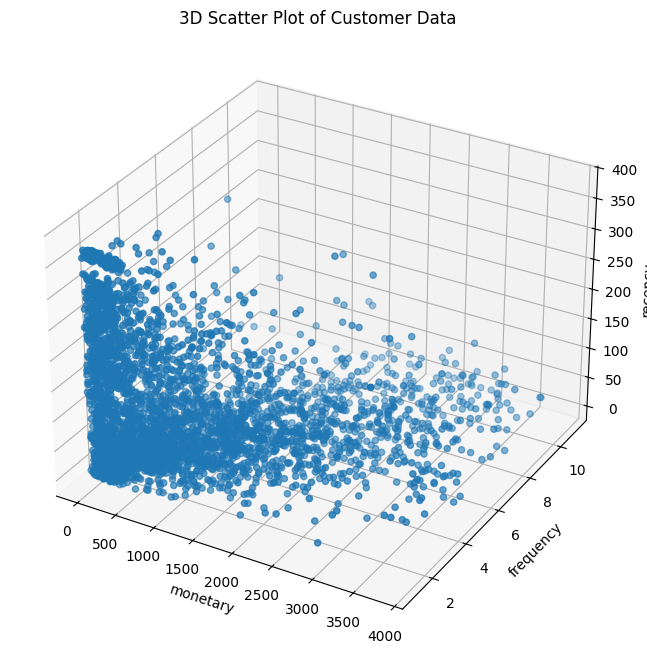

In [43]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["monetary"], non_outliers_df["frequency"], non_outliers_df["recency"])

ax.set_xlabel('monetary')
ax.set_ylabel('frequency')
ax.set_zlabel('recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

Standard scaling transforms the features of your data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- $z$ is the standardized value,
- $x$ is the original value,
- $\mu$ is the mean of the feature,
- $\sigma$ is the standard deviation of the feature.

In [44]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outliers_df[non_outliers_df.columns[1:]])
scaled_data = pd.DataFrame(scaled_data, index=non_outliers_df.index , columns=non_outliers_df.columns[1:])
scaled_data

,monetary,frequency,recency
0,-0.88,-0.39,0.68
1,0.52,-0.39,-0.97
2,-0.81,-0.83,-0.25
3,2.15,0.06,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4282,-0.30,1.40,-0.82
4283,-0.58,-0.83,-0.32
4284,-0.62,-0.83,2.01
4285,0.43,-0.39,0.14


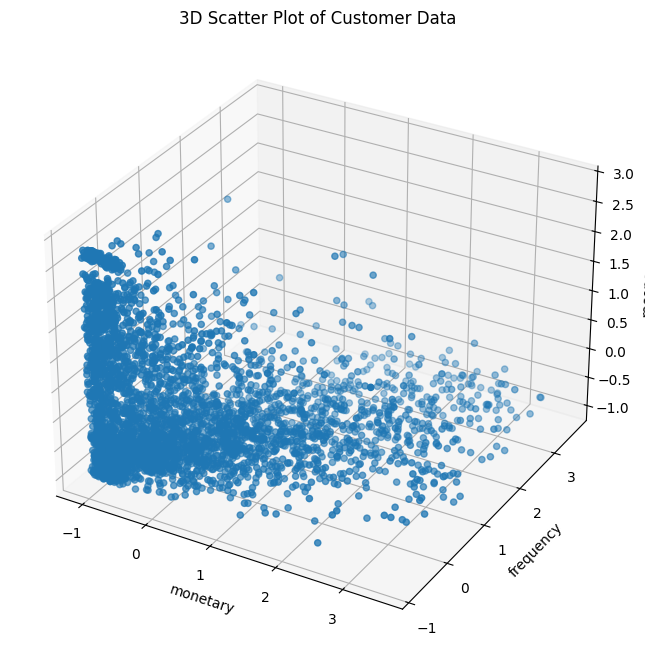

In [45]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data["monetary"], scaled_data["frequency"], scaled_data["recency"])

ax.set_xlabel('monetary')
ax.set_ylabel('frequency')
ax.set_zlabel('recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

## clustring

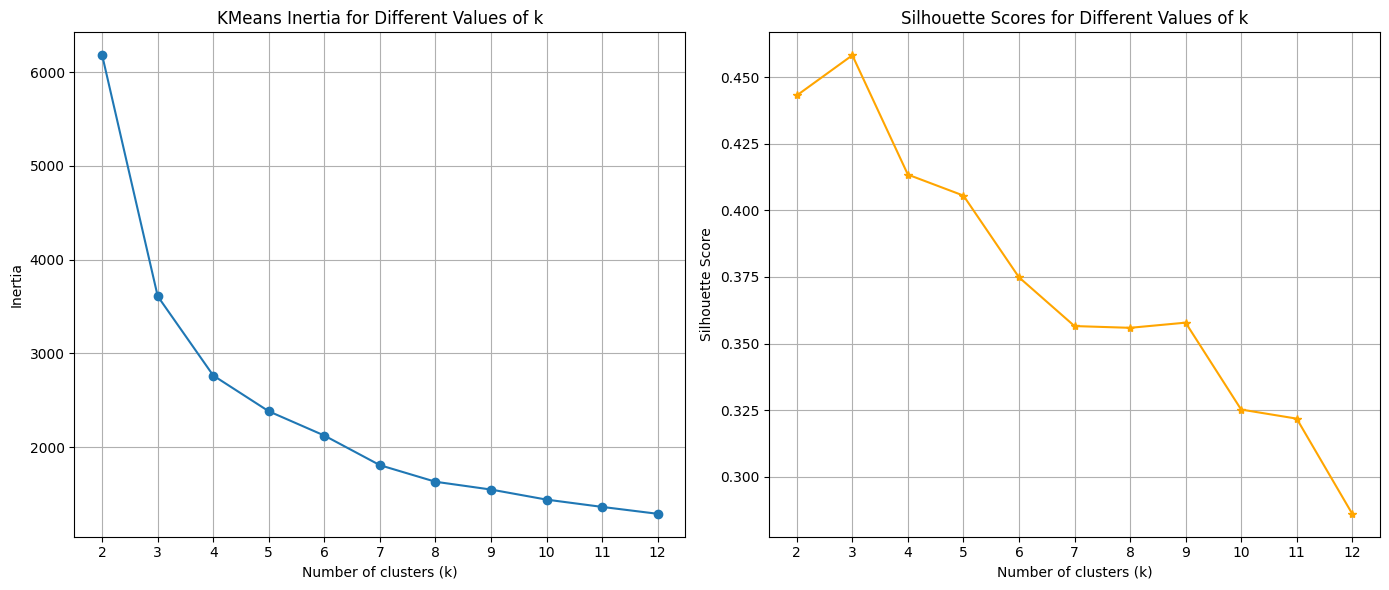

In [46]:
max_k = 12
inertia = []
silhouette_scores = []

k_values = range(2, max_k+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data)
    sil_score = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='*', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

### Silhouette Score

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Where:
- $s(i)$ is the silhouette score for a single sample $i$
- $a(i)$ is the average distance between $i$ and all other points in the same cluster,
- $b(i)$ is the minimum average distance between $i$ and all points in the nearest cluster to which $i$ does not belong.

The silhoutte score ranges between $[-1, 1]$, a higher value indicates more distinct clusters.

In [47]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data)

cluster_labels

array([3, 0, 2, ..., 3, 0, 0], dtype=int32)

In [48]:
non_outliers_df["cluster"] = cluster_labels

non_outliers_df

C:\Users\Raouf\AppData\Local\Temp\ipykernel_10972\2473124876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["cluster"] = cluster_labels


,customer_id,monetary,frequency,recency,cluster
0,12346.00,169.36,2,166,3
1,12347.00,1323.32,2,4,0
2,12348.00,222.16,1,75,2
3,12349.00,2671.14,3,44,0
4,12351.00,300.93,1,12,2
...,...,...,...,...,...
4282,18283.00,641.77,6,19,0
4283,18284.00,411.68,1,68,2
4284,18285.00,377.00,1,297,3
4285,18286.00,1246.43,2,113,0


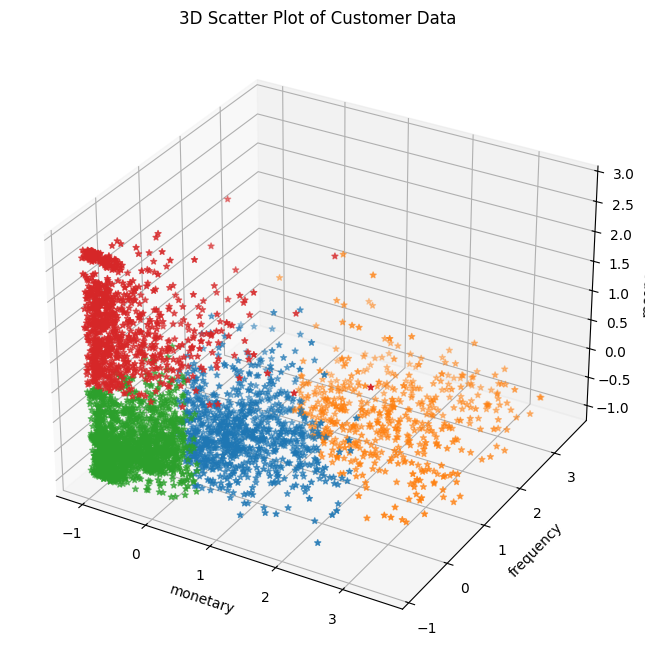

In [49]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['cluster'].map(cluster_colors)
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data["monetary"],
                     scaled_data["frequency"],
                     scaled_data["recency"],
                     c=colors,
                     marker='*')

ax.set_xlabel('monetary')
ax.set_ylabel('frequency')
ax.set_zlabel('recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

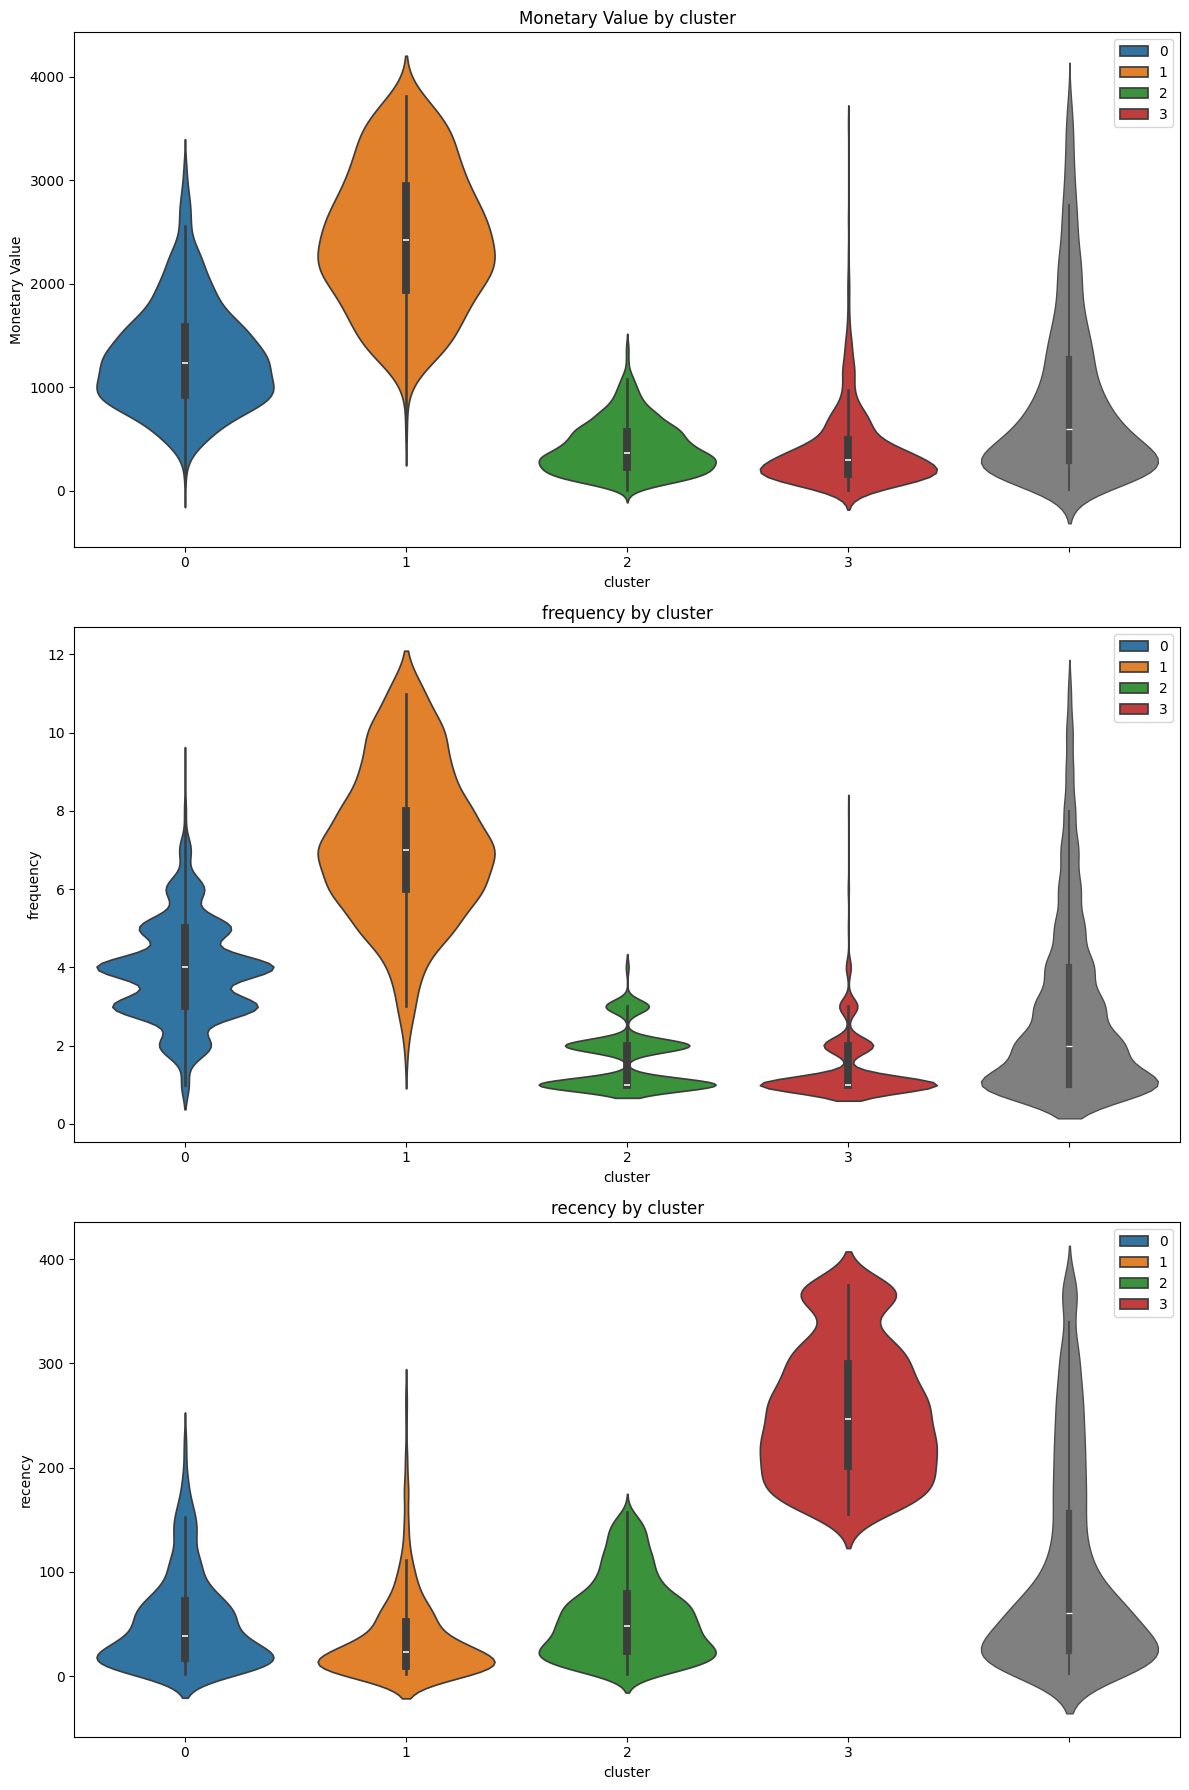

In [50]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['cluster'], y=non_outliers_df['monetary'], palette=cluster_colors, hue=non_outliers_df["cluster"])
sns.violinplot(y=non_outliers_df['monetary'], color='gray', linewidth=1.0)
plt.title('Monetary Value by cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['cluster'], y=non_outliers_df['frequency'], palette=cluster_colors, hue=non_outliers_df["cluster"])
sns.violinplot(y=non_outliers_df['frequency'], color='gray', linewidth=1.0)
plt.title('frequency by cluster')
plt.ylabel('frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['cluster'], y=non_outliers_df['recency'], palette=cluster_colors, hue=non_outliers_df["cluster"])
sns.violinplot(y=non_outliers_df['recency'], color='gray', linewidth=1.0)
plt.title('recency by cluster')
plt.ylabel('recency')

plt.tight_layout()
plt.show()

In [51]:
non_outliers_df[['monetary', 'frequency', 'recency', 'cluster']].groupby('cluster').describe().T

cluster                            0                    1  \
monetary  count               921.00               506.00   
          mean               1298.68              2443.90   
          std                 504.02               668.40   
          min                  97.40               628.32   
          25%                 924.52              1936.37   
          50%                1230.42              2419.99   
          75%                1579.07              2945.10   
          max                3138.04              3817.18   
frequency count               921.00               506.00   
          mean                  3.89                 7.19   
          std                   1.23                 1.90   
          min                   1.00                 2.00   
          25%                   3.00                 6.00   
          50%                   4.00                 7.00   
          75%                   5.00                 8.00   
          max                   9.00                11.00   
recency   count               921.00               506.00   
          mean                 51.50                36.52   
          std                  44.64                40.64   
          min                   2.00                 2.00   
          25%                  17.00                10.00   
          50%                  38.00                23.00   
          75%                  72.00                52.00   
          max                 230.00               271.00   

cluster                            2                    3  
monetary  count              1481.00               904.00  
          mean                416.34               391.68  
          std                 249.82               360.71  
          min                   3.75                 1.55  
          25%                 225.15               160.21  
          50%                 366.13               291.44  
          75%                 566.90               485.36  
          max                1399.36              3537.82  
frequency count              1481.00               904.00  
          mean                  1.63                 1.43  
          std                   0.73                 0.80  
          min                   1.00                 1.00  
          25%                   1.00                 1.00  
          50%                   1.00                 1.00  
          75%                   2.00                 2.00  
          max                   4.00                 8.00  
recency   count              1481.00               904.00  
          mean                 56.01               253.57  
          std                  38.28                62.88  
          min                   2.00               155.00  
          25%                  24.00               201.00  
          50%                  48.00               247.00  
          75%                  79.00               299.00  
          max                 157.00               375.00

In [85]:
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

# Example dataset creation for demonstration (replace with your data)
data = non_outliers_df.copy()
cluster_counts = data['cluster'].value_counts().sort_index()

# Define a mapping of cluster indices to colors
cluster_color_map = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red'
}

# Create a list of colors based on the cluster indices
cluster_colors = [cluster_color_map[i] for i in cluster_counts.index]

cluster_names = [f'Cluster {i}' for i in cluster_counts.index]

# Create the pie chart
pie_chart = go.Pie(
    labels=cluster_names,
    values=cluster_counts,
    textinfo='percent',
    hoverinfo='label+percent+value',
    textposition='inside',
    hole=.4,  # Doughnut style
    marker=dict(colors=cluster_colors, line=dict(color='black', width=1)),
    pull=[0.05] * len(cluster_counts),
    name='Customer Distribution',
    domain=dict(x=[0, 0.45]),
    
    
)

# Create the bar chart
bar_chart = go.Bar(
    x=cluster_names,
    y=cluster_counts,
    text=cluster_counts,
    textposition='outside',
    marker_color=cluster_colors,
    name='Cluster Counts',
    hoverinfo='x+y',
    textfont=dict(color='orange', size=14),
    
    
)

# Create layout
fig = go.Figure()
fig.add_trace(pie_chart)
fig.add_trace(bar_chart)

# Update layout for better visibility and spacing
fig.update_layout(
    title_text='Customer Segmentation: Pie and Bar Charts',
    
    showlegend=False,
    xaxis=dict(title='Clusters', domain=[0.55, 1],
               tickfont=dict(color='orange', size=14)
               ),
    yaxis=dict(title='Number of Customers',),
    xaxis_title_font_color='orange',
    yaxis_title_font_color='orange',
    bargap=0.3,
    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=80, b=50),
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=24,
    title_font_color='orange',
)

# Show the figure
fig.show()

## Customer Segmentation Insights

#### Overview
This analysis focuses on understanding customer segments based on their monetary value, frequency of purchases, and recency of interactions. The visualizations and summary statistics reveal distinct patterns across four clusters, allowing for targeted marketing strategies and tailored engagement efforts.

### Cluster Analysis

#### 1. **Cluster 0 (Blue)**: **"Moderate-Value, Infrequent, Active Recency"**
   - **Monetary Value**:  
     - Average value: **1,298.68**  
     - Range: **97.4** to **3,138.04**  
     - Represents customers with moderate spending patterns.  
   - **Frequency**:  
     - Average frequency: **3.89**  
     - Most customers have between 3 to 5 engagements.  
   - **Recency**:  
     - Average recency: **51.50**  
     - These customers have interacted relatively recently.  
     
   **Suggested Actions**:  
   - **Upsell and Cross-Sell**: Leverage mid-level promotions or recommend complementary products to increase their spending.
   - **Maintain Engagement**: Send reminders or product recommendations to keep them engaged and increase the frequency of purchases.

---

#### 2. **Cluster 1 (Orange)**: **"High-Value, High Frequency, Recent"**
   - **Monetary Value**:  
     - Average value: **2,443.90**  
     - Range: **628.32** to **3,817.18**  
     - This is the highest spending cluster, consisting of high-value customers.
   - **Frequency**:  
     - Average frequency: **7.19**  
     - Customers in this group have the highest interaction rates.
   - **Recency**:  
     - Average recency: **36.52**  
     - These customers have engaged very recently, indicating strong activity.  
     
   **Suggested Actions**:  
   - **Loyalty Programs**: Introduce exclusive deals and loyalty rewards to retain this valuable segment.
   - **Personalized Marketing**: Focus on personalized campaigns and exclusive offers to enhance customer experience.

---

#### 3. **Cluster 2 (Green)**: **"Low-Value, Low Frequency, Active Recency"**
   - **Monetary Value**:  
     - Average value: **416.34**  
     - Range: **3.75** to **1,399.36**  
     - Lowest monetary value among the clusters.
   - **Frequency**:  
     - Average frequency: **1.63**  
     - Customers engage infrequently, with only 1 to 2 purchases on average.
   - **Recency**:  
     - Average recency: **56.01**  
     - These customers have been active in recent times, presenting potential for re-engagement.  
     
   **Suggested Actions**:  
   - **Educational Campaigns**: Use awareness campaigns to inform them about products and promotions.
   - **Incentivize Engagement**: Implement bundle offers or small discounts to increase purchase frequency and boost their average spending.

---

#### 4. **Cluster 3 (Red)**: **"Low-Value, Infrequent, Very Inactive Recency"**
   - **Monetary Value**:  
     - Average value: **391.68**  
     - Range: **1.55** to **3,537.82**  
     - Spending patterns are very low, similar to Cluster 2.
   - **Frequency**:  
     - Average frequency: **1.43**  
     - Customers engage infrequently, with very low interaction rates.
   - **Recency**:  
     - Average recency: **253.57**  
     - Highest recency value across all clusters, indicating these customers have not been active for a significant amount of time.  
     
   **Suggested Actions**:  
   - **Reactivation Campaigns**: Utilize re-engagement discounts or personalized emails to understand why these customers became inactive.
   - **Surveys & Feedback**: Conduct surveys to gather insights on their disengagement and identify areas for improvement.

---

### Key Takeaways
- **Cluster 1 (Orange)** is the primary segment to focus retention strategies on, as they have high value and recent engagement.
- **Cluster 0 (Blue)** represents a stable customer group that could be targeted for upselling or increasing frequency.
- **Clusters 2 and 3 (Green and Red)** require efforts to increase engagement and spending, especially Cluster 3, which needs reactivation strategies.

These insights can guide data-driven marketing strategies and resource allocation for customer management.


In [284]:
cluster_labels = {
0: 'mentain engagement',
1: 'reward customers',
2: 'educate customers',
3: 'reactivate customers'
}

In [285]:
non_outliers_df['cluster_labels'] = non_outliers_df['cluster'].map(cluster_labels)
non_outliers_df

C:\Users\Raouf\AppData\Local\Temp\ipykernel_6468\1103994729.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,customer_id,monetary,frequency,recency,cluster,cluster_labels
0,12346.00,169.36,2,166,3,reactivate customers
1,12347.00,1323.32,2,4,0,mentain engagement
2,12348.00,222.16,1,75,2,educate customers
3,12349.00,2671.14,3,44,0,mentain engagement
4,12351.00,300.93,1,12,2,educate customers
...,...,...,...,...,...,...
4282,18283.00,641.77,6,19,0,mentain engagement
4283,18284.00,411.68,1,68,2,educate customers
4284,18285.00,377.00,1,297,3,reactivate customers
4285,18286.00,1246.43,2,113,0,mentain engagement


In [286]:
non_outliers_df['cluster_labels'].value_counts()

cluster_labels
educate customers       1481
mentain engagement       921
reactivate customers     904
reward customers         506
Name: count, dtype: int64

C:\Users\Raouf\AppData\Local\Temp\ipykernel_6468\4232178497.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Raouf\AppData\Local\Temp\ipykernel_6468\4232178497.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



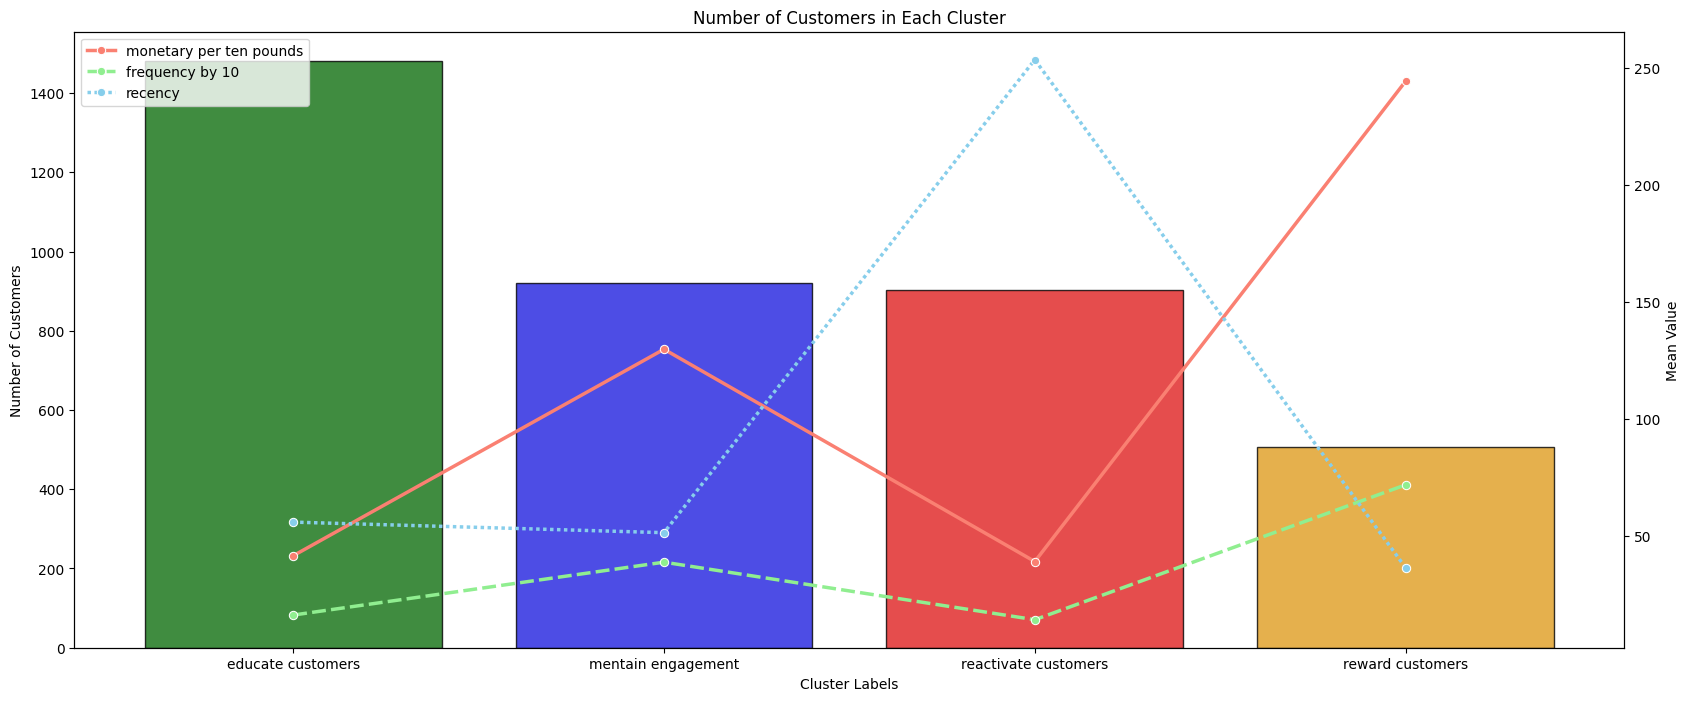

In [287]:
cluster_counts = non_outliers_df['cluster_labels'].value_counts()
non_outliers_df['monetary per ten pounds'] = non_outliers_df['monetary'] / 10 # to make the numbers easier to read
non_outliers_df['frequency by 10'] = non_outliers_df['frequency'] * 10 # to make the numbers visible on the plot
features = ['monetary per ten pounds', 'frequency by 10', 'recency']
feature_means = non_outliers_df.groupby('cluster_labels')[features].mean()

cluster_counts_numbers = non_outliers_df['cluster'].value_counts()
cluster_color_map = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red'
}

# Create a list of colors based on the cluster indices
cluster_colors = [cluster_color_map[i] for i in cluster_counts_numbers.index]
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax, alpha=0.8, edgecolor='black', linewidth=1, zorder=2, label='Number of Customers', hue=cluster_counts.index ,palette=cluster_colors)
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Cluster Labels')
ax.set_title('Number of Customers in Each Cluster')

colosrs = ['salmon', 'lightgreen', 'skyblue']
ax2 = ax.twinx()
sns.lineplot(data=feature_means, ax=ax2, palette=colosrs, marker='o', linewidth=2.5, zorder=1)
ax2.set_ylabel('Mean Value')



plt.show()


# I Know that i neglected some of the data but i will come back to do it later


# THIS IS A LONG NOTEBOOK BUT I HOPE YOU FIND IT HELPFUL AND INFORMATIVE
# THANK YOU
